# WP1 - Anomaly subgraph extraction: Finding anomalies

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from anomaly_detection import detect_anomalies
from temporal_graph_generation import sample_subgraph, sample_subgraph_with_timestamp_constraint, add_timesteps_to_graph

In [2]:
graph = nx.read_graphml("../data/causality_chi2.graphml")
graph = graph.to_undirected()

/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id id. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id labels. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id causal. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id label. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")


In [3]:
full_data = pd.read_csv('../data/loadtest-timestamp.csv')
full_data[['Date', 'Time']] = full_data['Time'].str.split(" ", expand=True)
full_data = full_data.sort_values(by=['Date','Time'])
full_data

,Unnamed: 0,Time,carts,carts-db,catalogue,catalogue-db,front-end,orders,orders-db,payment,queue-master,rabbitmq,session-db,shipping,user,user-db,Date
674,674,11:27,0.00245,0.00824,0.00129,0.001150,0.00313,0.00260,0.00901,0.001250,0.00254,0.0145,0.00232,0.00223,0.00178,0.00942,10/14/2021
675,675,11:28,0.00279,0.01020,0.00128,0.001080,0.00352,0.00273,0.00974,0.001310,0.00249,0.0136,0.00268,0.00235,0.00191,0.01060,10/14/2021
676,676,11:29,0.00345,0.00929,0.00140,0.001180,0.00379,0.00262,0.00938,0.001370,0.00329,0.0132,0.00260,0.00214,0.00198,0.01020,10/14/2021
677,677,11:30,0.00233,0.00890,0.00108,0.001120,0.00343,0.00227,0.00783,0.001300,0.00239,0.0113,0.00223,0.00221,0.00173,0.00869,10/14/2021
678,678,11:31,0.00421,0.00914,0.00148,0.001380,0.00405,0.00297,0.00980,0.001410,0.00250,0.0127,0.00259,0.00234,0.00233,0.01030,10/14/2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,527,20:33,0.00312,0.01000,0.00139,0.000967,0.00300,0.00320,0.00924,0.001150,0.00214,0.0152,0.00238,0.00187,0.00234,0.00920,3/2/2022
528,528,20:34,0.00252,0.01080,0.00116,0.001060,0.00311,0.00259,0.01050,0.001480,0.00210,0.0118,0.00260,0.00220,0.00195,0.00965,3/2/2022
529,529,20:35,0.00311,0.01030,0.00134,0.001460,0.00366,0.00278,0.01060,0.001330,0.00222,0.0122,0.00247,0.00271,0.00237,0.01090,3/2/2022
530,530,20:36,0.00220,0.01030,0.00102,0.000994,0.00334,0.00458,0.00998,0.000969,0.00222,0.0128,0.00241,0.00213,0.00180,0.00955,3/2/2022


In [4]:
detect_anomalies(full_data, graph, ['2/17/2022', '3/2/2022'], ['10/14/2021', '10/19/2021', '10/20/2021'])

Node names from data csv:  ['carts', 'carts-db', 'catalogue', 'catalogue-db', 'front-end', 'orders', 'orders-db', 'payment', 'queue-master', 'rabbitmq', 'session-db', 'shipping', 'user', 'user-db']
Node names from graph:  ['carts', 'carts-db', 'catalogue', 'catalogue-db', 'front-end', 'master', 'orders', 'orders-db', 'payment', 'queue-master', 'rabbitmq', 'session-db', 'shipping', 'user', 'user-db', 'worker1', 'worker2']
Nodes in graph but not in data csv:  ['master', 'worker1', 'worker2']
Nodes in data csv but not in graph:  []


100%|██████████| 589/589 [00:00<00:00, 977.39it/s] 

Traceback (most recent call last):
  File "/Users/lisa/Documents/GitHub/Spatio-Temporal-Graphs/src/anomaly_detection.py", line 28, in detect_anomalies
    s.initialize(verbose=False) 		# initialization step
  File "/Users/lisa/Documents/GitHub/Spatio-Temporal-Graphs/src/spot.py", line 199, in initialize
    g,s,l = self._grimshaw()
  File "/Users/lisa/Documents/GitHub/Spatio-Temporal-Graphs/src/spot.py", line 345, in _grimshaw
    right_zeros = SPOT._rootsFinder(lambda t: w(self.peaks,t),
  File "/Users/lisa/Documents/GitHub/Spatio-Temporal-Graphs/src/spot.py", line 238, in _rootsFinder
    X0 = np.arange(bounds[0]+step,bounds[1],step)
ValueError: arange: cannot compute length




/Users/lisa/Documents/GitHub/Spatio-Temporal-Graphs/src/spot.py:238: RuntimeWarning: invalid value encountered in double_scalars
  X0 = np.arange(bounds[0]+step,bounds[1],step)


In [5]:
remove_edges = [e for e in graph.edges(data=True) if e[2].get('causal')!='true']
graph.remove_edges_from(remove_edges)


In [6]:
frontend_node = [n for n in graph.nodes.data() if n[1]["id"] == "front-end"][0]

### Sample subgraph with dfs/bfs tree combination

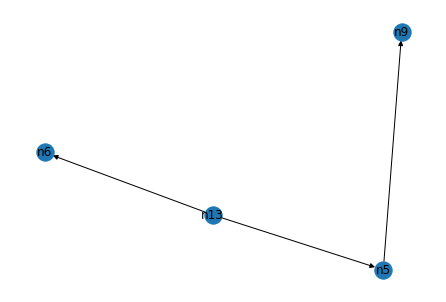

In [7]:
MAXLAG = 2
DATETIME_FORMAT = "%m/%d/%Y %H:%M"

tg= sample_subgraph_with_timestamp_constraint(graph, frontend_node[0], bfs_prob=0.5, random_seed=111, start_timestamp='3/2/2022 13:22', datetime_format=DATETIME_FORMAT, maxlag=MAXLAG)
nx.draw(tg, with_labels=True)

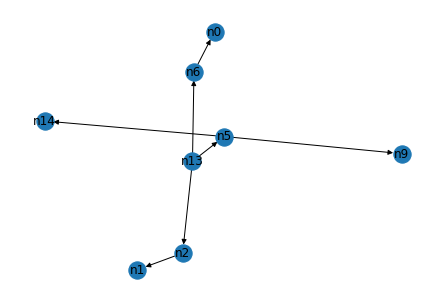

In [30]:
subgraph = sample_subgraph(graph, frontend_node[0], max_nodes=8, bfs_prob=0.5, random_seed=111)
nx.draw(subgraph, with_labels=True)

In [31]:
add_timesteps_to_graph(subgraph, frontend_node[0])

{('n13', 'n2'): Text(-0.2444527757252524, -0.1388122480497892, '4'),
 ('n13', 'n5'): Text(0.23556868434046982, -0.11801757482151622, '0'),
 ('n13', 'n6'): Text(-0.05317723257002151, 0.2959930641031816, '2'),
 ('n2', 'n1'): Text(-0.567657461551484, -0.361518559666374, '6'),
 ('n5', 'n14'): Text(0.6955234516265407, 0.12566626513456433, '3'),
 ('n5', 'n9'): Text(0.2773627111485452, -0.6255122008510313, '1'),
 ('n6', 'n0'): Text(-0.15244696820556683, 0.7283576685022944, '5')}

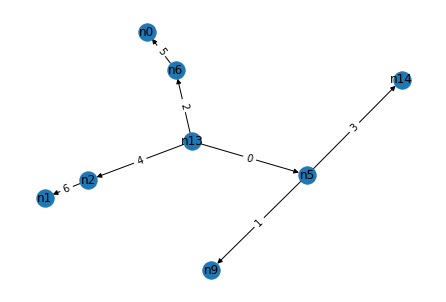

In [32]:
nx.draw(subgraph, nx.spring_layout(subgraph, seed=7), with_labels=True)
edge_labels = nx.get_edge_attributes(subgraph, "timestep")
nx.draw_networkx_edge_labels(subgraph, nx.spring_layout(subgraph, seed=7), edge_labels)
#plt.tight_layout()


## Test temporal centralities

In [33]:
edge_df = nx.to_pandas_edgelist(subgraph)
edge_df.columns = ['i','j','t']
edge_df = edge_df.replace(to_replace=r'^n', value='', regex=True)
edge_df = edge_df.apply(pd.to_numeric)
edge_df

,i,j,t
0,13,2,4
1,13,5,0
2,13,6,2
3,2,1,6
4,5,14,3
5,5,9,1
6,6,0,5


In [34]:
add_edges = []
max_time = np.max(edge_df['t'])
for i in edge_df.index:
    row = edge_df.iloc[i]
    times_to_add = np.arange(row["t"], max_time+1)
    for t_to_add in times_to_add:
        add_edges.append([row["i"], row["j"], t_to_add])

In [35]:
fill_edges = pd.DataFrame(add_edges, columns=edge_df.columns)
fill_edges

,i,j,t
0,13,2,4
1,13,2,5
2,13,2,6
3,13,5,0
4,13,5,1
5,13,5,2
6,13,5,3
7,13,5,4
8,13,5,5
9,13,5,6


In [14]:
#%pip install teneto

In [36]:
from teneto import TemporalNetwork
import teneto
tnet = TemporalNetwork(from_df=fill_edges)

In [37]:
tnet.network

,i,j,t
0,13,2,4
1,13,2,5
2,13,2,6
3,13,5,0
4,13,5,1
5,13,5,2
6,13,5,3
7,13,5,4
8,13,5,5
9,13,5,6


In [ ]:
closeness_centrality =  teneto.networkmeasures.temporal_closeness_centrality(tnet=tnet)

In [18]:
closeness_centrality

array([0.        , 0.        , 0.02380952, 0.        , 0.        ,
       0.05952381, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.23187229, 0.        ])

In [19]:
existing_temporal_paths = teneto.networkmeasures.shortest_temporal_path(tnet, minimise='temporal_distance')

In [21]:
existing_temporal_paths.dropna(how='all', subset=['path includes'])

,from,to,t_start,temporal-distance,topological-distance,path includes
145,2,1,0,5.0,1.0,"[[2, 1]]"
146,2,1,1,4.0,1.0,"[[2, 1]]"
147,2,1,2,3.0,1.0,"[[2, 1]]"
148,2,1,3,2.0,1.0,"[[2, 1]]"
149,2,1,4,1.0,1.0,"[[2, 1]]"
415,5,14,0,2.0,1.0,"[[5, 14]]"
416,5,14,1,1.0,1.0,"[[5, 14]]"
417,5,14,2,1.0,1.0,"[[5, 14]]"
418,5,14,3,1.0,1.0,"[[5, 14]]"
419,5,14,4,1.0,1.0,"[[5, 14]]"


In [25]:
pd.Series(teneto.networkmeasures.temporal_degree_centrality(tnet=tnet))

0      0.0
1      0.0
2      1.0
3      0.0
4      0.0
5      4.0
6      0.0
7      0.0
8      0.0
9      0.0
10     0.0
11     0.0
12     0.0
13    10.0
14     0.0
dtype: float64

In [26]:
betweenness_centrality =  teneto.networkmeasures.temporal_betweenness_centrality(tnet=tnet)

In [29]:
betweenness_centrality

array([[0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.0010989, 0.0010989, 0.0010989, 0.0010989, 0.0010989],
       [0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.0010989, 0.0010989, 0.0010989, 0.0010989, 0.0010989],
       [0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       ]])

In [23]:
print(frontend_node[1]["anomaly_timestamps"])

['3/2/2022 11:50', '3/2/2022 13:22', '3/2/2022 15:47', '3/2/2022 17:48']


In [24]:
print([graph.nodes[node] for node in list(graph.neighbors(frontend_node[0]))])

[{'labels': ':Node', 'id': 'user-db'}, {'labels': ':Node', 'id': 'orders-db', 'anomaly': True, 'anomaly_timestamps': ['3/2/2022 12:13', '3/2/2022 13:22', '3/2/2022 13:23', '3/2/2022 17:39', '3/2/2022 19:41']}, {'labels': ':Node', 'id': 'carts-db', 'anomaly': True, 'anomaly_timestamps': ['3/2/2022 13:22', '3/2/2022 13:23']}]
